The Below is the Model Architecture

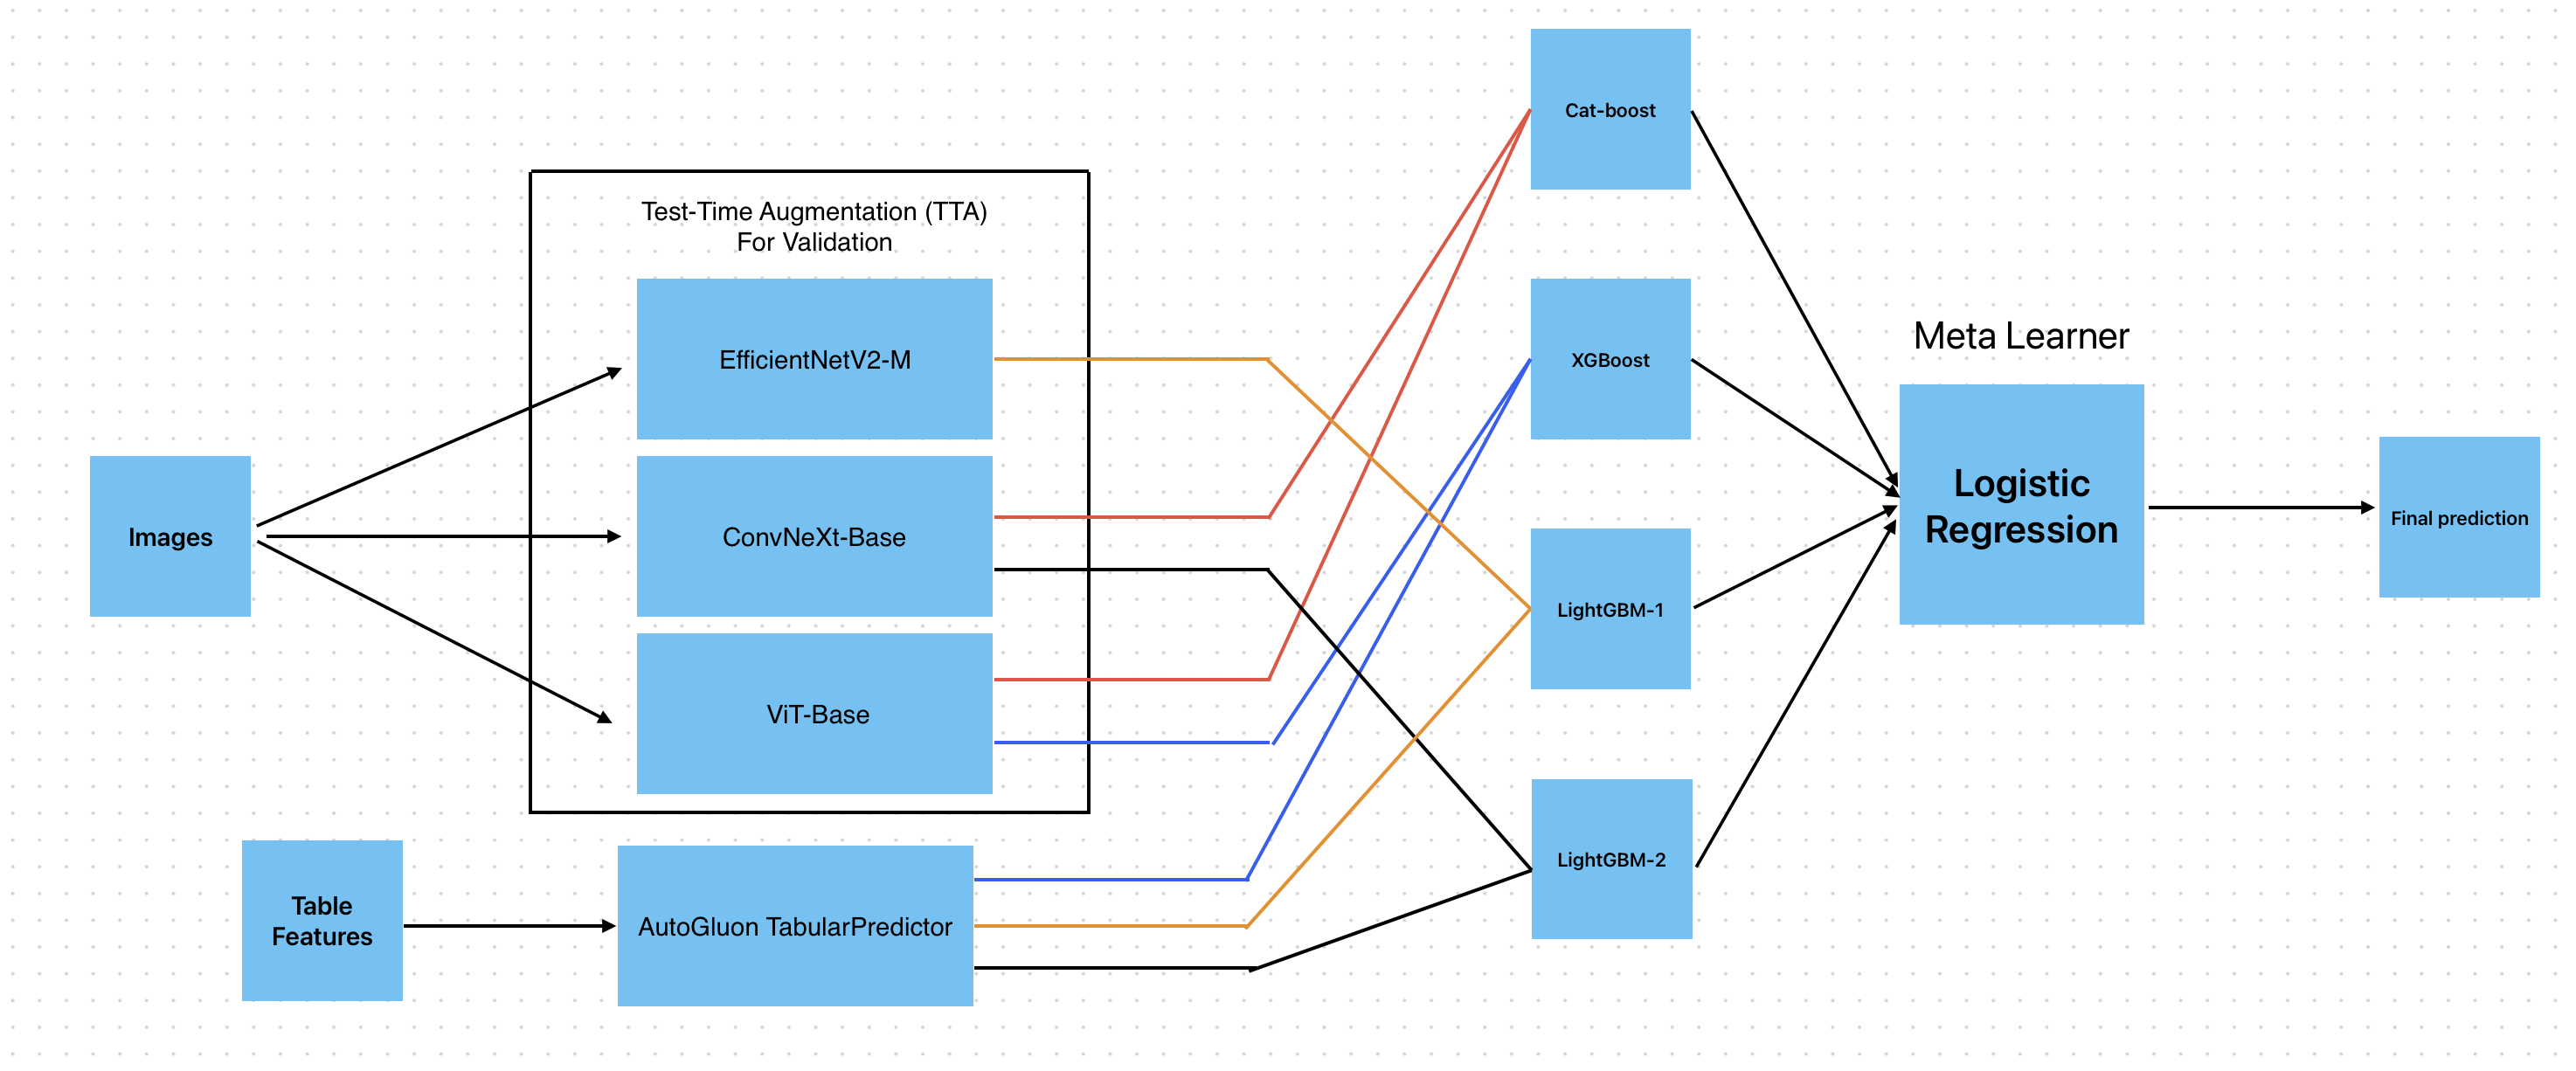

Also Here Optuna is used for Hyperparameter Tuning

In [1]:
import os
import time
from pathlib import Path
import io

import numpy as np
import pandas as pd
import polars as pl
from PIL import Image
import h5py

from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import optuna


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import timm 


from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm

from autogluon.tabular import TabularPredictor


import albumentations as A
from albumentations.pytorch import ToTensorV2


In [2]:
SUBJECT_DATA_PATH = 'subject_data.csv'
IMAGE_HDF5_PATH = 'images.hdf5' 
OUTPUT_PREDICTIONS_PATH = 'predictions_autogluon_stacked_cv.csv'

ID_COL = 'isic_id'
TARGET_COL = 'target'
GROUP_COL = 'patient_id'
SEED = 42
ERR = 1e-5
TARGET_0_SAMPLE_SIZE = 3000
N_SPLITS = 10


IMAGE_MODELS = {
    'effnet': 'tf_efficientnetv2_m.in21k',
    'convnext': 'convnextv2_base.fcmae_ft_in22k_in1k',
    'vit': 'vit_base_patch16_224.augreg_in21k_ft_in1k'
}
IMAGE_SIZE = 224
IMAGE_BATCH_SIZE = 32 
FINETUNE_EPOCHS = 4
FINETUNE_LR = 1e-4
TTA_STEPS = 4
OPTUNA_TRIALS = 30 


DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for PyTorch: {DEVICE}")

Using device for PyTorch: mps


In [3]:
class HDF5ImageDataset(Dataset):
    def __init__(self, df, hdf5_path, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.hdf5_path = hdf5_path
        self.transform = transform
        self.is_test = is_test
        self.hdf5_file = None
        self.isic_ids = self.df[ID_COL].tolist()

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        if self.hdf5_file is None:
            self.hdf5_file = h5py.File(self.hdf5_path, 'r')
        
        isic_id = self.isic_ids[idx]
        try:
            image_bytes = self.hdf5_file[isic_id][()]
            image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        except KeyError:
            print(f"Warning: Image ID {isic_id} not found. Using a black image.")
            image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color='black')
        
        image_np = np.array(image)

        if self.transform:
            augmented = self.transform(image=image_np)
            image = augmented['image']

        if self.is_test:
            return image
        else:
            target = torch.tensor(self.df.iloc[idx][TARGET_COL], dtype=torch.float32)
            return image, target
    
    def close(self):
        if self.hdf5_file:
            self.hdf5_file.close()
            self.hdf5_file = None


In [4]:
def get_transforms(image_size, is_train=True):
    if is_train:
        return A.Compose([
            A.Transpose(p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
            A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.GaussianBlur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
            ], p=0.7),
            A.OneOf([
                A.OpticalDistortion(distort_limit=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.),
                A.ElasticTransform(alpha=3),
            ], p=0.7),
            A.CLAHE(clip_limit=4.0, p=0.7),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
            A.Resize(image_size, image_size),
            A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),    
            A.Normalize(),
            ToTensorV2()
        ])
    else:
        return A.Compose([A.Resize(image_size, image_size), A.Normalize(), ToTensorV2()])


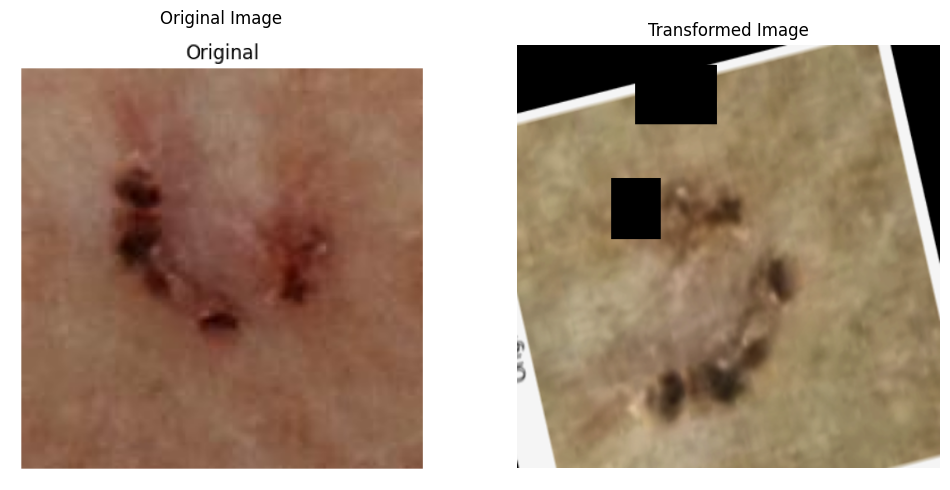

In [5]:
def get_tta_transforms(image_size):
    base_transform = [A.Resize(image_size, image_size), A.Normalize(), ToTensorV2()]
    tta_transforms = [
        A.Compose(base_transform),
        A.Compose([A.HorizontalFlip(p=1.0)] + base_transform),
        A.Compose([A.VerticalFlip(p=1.0)] + base_transform),
        A.Compose([A.Transpose(p=1.0)] + base_transform),
    ]
    return tta_transforms[:TTA_STEPS]


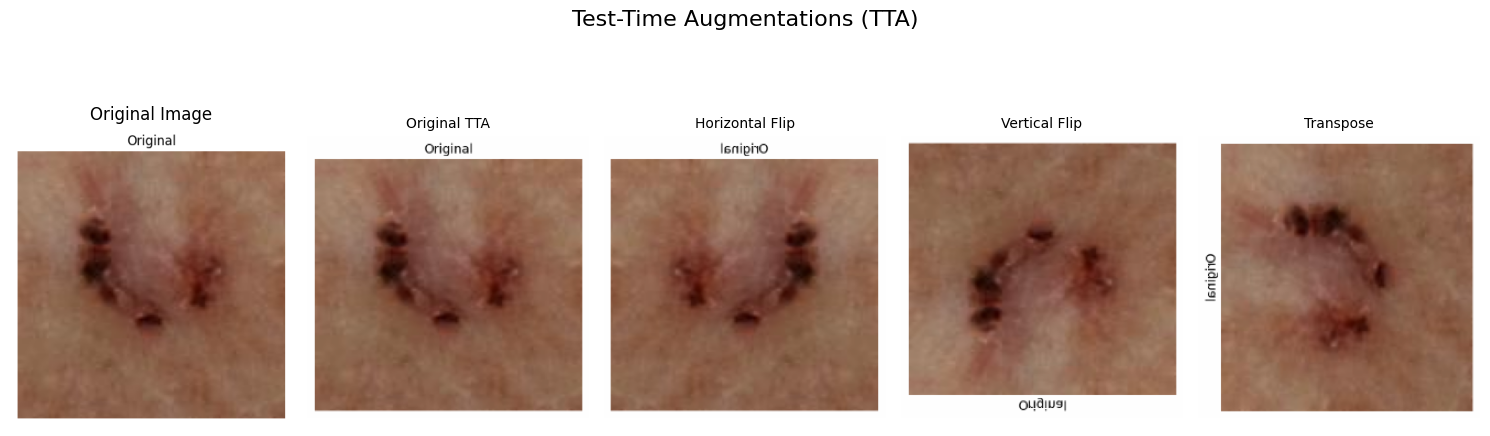

In [6]:
class ImageFineTuningModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.feature_dim = self.backbone.num_features
        
        for param in self.backbone.parameters():
            param.requires_grad = False

        if hasattr(self.backbone, 'stages'):
            for param in self.backbone.stages[-1].parameters(): param.requires_grad = True
        elif hasattr(self.backbone, 'blocks'):
             for param in self.backbone.blocks[-1].parameters(): param.requires_grad = True
        if hasattr(self.backbone, 'head'):
            for param in self.backbone.head.parameters(): param.requires_grad = True
        
        self.classifier = nn.Linear(self.feature_dim, 1)

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output, features

In [7]:
def run_image_model_finetuning_and_extraction(model_name, train_df, val_df, pos_weight):
    print(f"\n--- Fine-Tuning and Extracting for {model_name} ---")
    
    train_dataset = HDF5ImageDataset(train_df, IMAGE_HDF5_PATH, transform=get_transforms(IMAGE_SIZE, is_train=True))
    train_loader = DataLoader(train_dataset, batch_size=IMAGE_BATCH_SIZE, shuffle=True, num_workers=0)
    
    model = ImageFineTuningModel(model_name).to(DEVICE)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=FINETUNE_LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FINETUNE_EPOCHS)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    for epoch in range(FINETUNE_EPOCHS):
        model.train()
        total_loss = 0
        for images, targets in train_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE).unsqueeze(1)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"  Epoch {epoch+1}/{FINETUNE_EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")

    model.eval()
    
    train_feat_dataset = HDF5ImageDataset(train_df, IMAGE_HDF5_PATH, transform=get_transforms(IMAGE_SIZE, is_train=False), is_test=True)
    train_feat_loader = DataLoader(train_feat_dataset, batch_size=IMAGE_BATCH_SIZE, shuffle=False, num_workers=0)
    train_features = []
    with torch.no_grad():
        for images in train_feat_loader:
            _, features = model(images.to(DEVICE))
            train_features.append(features.cpu())
    
    tta_transforms = get_tta_transforms(IMAGE_SIZE)
    val_features_tta = []
    for tta_transform in tta_transforms:
        val_feat_dataset = HDF5ImageDataset(val_df, IMAGE_HDF5_PATH, transform=tta_transform, is_test=True)
        val_feat_loader = DataLoader(val_feat_dataset, batch_size=IMAGE_BATCH_SIZE, shuffle=False, num_workers=0)
        val_features_single_run = []
        with torch.no_grad():
            for images in val_feat_loader:
                _, features = model(images.to(DEVICE))
                val_features_single_run.append(features.cpu())
        val_features_tta.append(torch.cat(val_features_single_run))

    avg_val_features = torch.mean(torch.stack(val_features_tta), dim=0)
    
    all_features = torch.cat([torch.cat(train_features), avg_val_features]).numpy()
    
    feature_prefix = model_name.split('.')[0].replace('_', '')
    df_fold = pd.concat([train_df, val_df], ignore_index=True)
    image_df = pd.DataFrame(all_features, columns=[f'{feature_prefix}_feat_{i}' for i in range(all_features.shape[1])])
    image_df[ID_COL] = df_fold[ID_COL].values
    
    train_dataset.close()
    return image_df


In [8]:
def autogluon_feature_engineering(train_df, val_df):
    print("\n--- Generating features with AutoGluon ---")
    
    original_tabular_cols = [ 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution',  'lesion_id',
       'mel_mitotic_index', 'mel_thick_mm']
    
    train_ag = train_df[[ID_COL, TARGET_COL] + [c for c in original_tabular_cols if c in train_df.columns]].copy()
    val_ag = val_df[[ID_COL, TARGET_COL] + [c for c in original_tabular_cols if c in val_df.columns]].copy()

    predictor = TabularPredictor(label=TARGET_COL, verbosity=0)
    
    predictor.fit(train_ag, time_limit=300, presets='medium_quality')

    train_features = predictor.transform_features(train_ag)
    val_features = predictor.transform_features(val_ag)
    
    all_features = pd.concat([train_features, val_features]).reset_index(drop=True)
    all_features[ID_COL] = pd.concat([train_ag[ID_COL], val_ag[ID_COL]]).reset_index(drop=True)
    
    return all_features


In [ ]:
if __name__ == '__main__':
    start_time = time.time()

    print("\n--- Step 0: Loading and Sampling Data ---")
    df_all_subjects = pd.read_csv(SUBJECT_DATA_PATH)
    df_target1 = df_all_subjects[df_all_subjects[TARGET_COL] == 1]
    df_target0 = df_all_subjects[df_all_subjects[TARGET_COL] == 0]
    n_sample = min(TARGET_0_SAMPLE_SIZE, len(df_target0))
    df_target0_sampled = df_target0.sample(n=n_sample, random_state=SEED)
    df_sampled = pd.concat([df_target1, df_target0_sampled]).reset_index(drop=True)

    # --- Step 0.5: Create Hold-Out Test Set ---
    print("\n--- Step 0.5: Creating Hold-Out Test Set ---")
    train_val_df, test_df = train_test_split(
        df_sampled,
        test_size=0.20,
        random_state=SEED,
        stratify=df_sampled[TARGET_COL]
    )
    print(f"Train/Validation set size for CV: {train_val_df.shape[0]}")
    print(f"Hold-out test set size: {test_df.shape[0]}")

    skf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    oof_level0_preds = []
    oof_trues = []
    oof_ids = []

    model_names = ['catboost', 'xgb', 'lgb1', 'lgb2']

    # This loop generates out-of-fold predictions to train the meta-learner
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_df, train_val_df[TARGET_COL], train_val_df[GROUP_COL])):
        print(f"\n===== FOLD {fold+1}/{N_SPLITS} (Meta-Learner Training) =====")
        train_df, val_df = train_val_df.iloc[train_idx], train_val_df.iloc[val_idx]

        # Steps 1-3: Feature Generation for the fold
        all_image_features_fold = []
        for model_key, model_name in IMAGE_MODELS.items():
            pos_weight = torch.tensor([len(train_df) / (2 * train_df[TARGET_COL].sum())], device=DEVICE, dtype=torch.float32)
            features_df = run_image_model_finetuning_and_extraction(model_name, train_df, val_df, pos_weight)
            all_image_features_fold.append(features_df)
        all_image_features_df = all_image_features_fold[0]
        for i in range(1, len(all_image_features_fold)):
            all_image_features_df = pd.merge(all_image_features_df, all_image_features_fold[i], on=ID_COL, how='left')

        autogluon_features_df = autogluon_feature_engineering(train_df, val_df)
        fold_df = pd.merge(all_image_features_df, autogluon_features_df, on=ID_COL, how='left')

        fold_train_df = pd.merge(fold_df[fold_df[ID_COL].isin(train_df[ID_COL])], train_df[[ID_COL, TARGET_COL]], on=ID_COL, how='left')
        fold_val_df = pd.merge(fold_df[fold_df[ID_COL].isin(val_df[ID_COL])], val_df[[ID_COL, TARGET_COL]], on=ID_COL, how='left')

        # Step 4: Hyperparameter Optimization
        def objective(trial):
            params = {
                'catboost': {'iterations': 1000, 'learning_rate': trial.suggest_float('cat_lr', 1e-3, 0.1, log=True), 'depth': trial.suggest_int('cat_d', 4, 10)},
                'xgb': {'n_estimators': 1000, 'learning_rate': trial.suggest_float('xgb_lr', 1e-3, 0.1, log=True), 'max_depth': trial.suggest_int('xgb_d', 3, 9)},
                'lgb': {'n_estimators': 1000, 'learning_rate': trial.suggest_float('lgb_lr', 1e-3, 0.1, log=True), 'num_leaves': trial.suggest_int('lgb_nl', 20, 300)}
            }
            effnet_feats = [c for c in fold_train_df.columns if 'effnet' in c]
            tabular_feats = [c for c in autogluon_features_df.columns if c not in [ID_COL, TARGET_COL]]
            X_train_hpo, y_train_hpo = fold_train_df[effnet_feats + tabular_feats].values, fold_train_df[TARGET_COL].values
            X_val_hpo, y_val_hpo = fold_val_df[effnet_feats + tabular_feats].values, fold_val_df[TARGET_COL].values
            model = lightgbm.LGBMClassifier(**params['lgb'], random_state=SEED, verbosity=-1)
            model.fit(X_train_hpo, y_train_hpo, eval_set=[(X_val_hpo, y_val_hpo)], callbacks=[lightgbm.early_stopping(50, verbose=False)])
            preds = model.predict_proba(X_val_hpo)[:, 1]
            return f1_score(y_val_hpo, preds > 0.5)

        print("\n--- Starting HPO for Fold ---")
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=OPTUNA_TRIALS)
        best_params = study.best_params
        print(f"Fold {fold+1} Best HPO Params Found: {best_params}")

        # Step 5: Final Training on Fold
        effnet_feats = [c for c in fold_train_df.columns if 'effnet' in c]
        convnext_feats = [c for c in fold_train_df.columns if 'convnext' in c]
        vit_feats = [c for c in fold_train_df.columns if 'vit' in c]
        tabular_feats = [c for c in autogluon_features_df.columns if c not in [ID_COL, TARGET_COL]]
        features = {
            'catboost': convnext_feats + vit_feats, 'xgb': vit_feats + tabular_feats,
            'lgb1': effnet_feats + tabular_feats, 'lgb2': convnext_feats + tabular_feats
        }
        final_params = {
            'catboost': {'learning_rate': best_params['cat_lr'], 'depth': best_params['cat_d'], 'n_estimators': 1000},
            'xgb': {'learning_rate': best_params['xgb_lr'], 'max_depth': best_params['xgb_d'], 'n_estimators': 1000},
            'lgb1': {'learning_rate': best_params['lgb_lr'], 'num_leaves': best_params['lgb_nl'], 'n_estimators': 1000},
            'lgb2': {'learning_rate': best_params['lgb_lr'], 'num_leaves': best_params['lgb_nl'], 'n_estimators': 1000}
        }
        scale_pos_weight = train_df[TARGET_COL].value_counts()[0] / train_df[TARGET_COL].value_counts()[1]
        models = {
            'catboost': CatBoostClassifier(**final_params['catboost'], random_state=SEED, verbose=0),
            'xgb': XGBClassifier(**final_params['xgb'], random_state=SEED, eval_metric='logloss', scale_pos_weight=scale_pos_weight, early_stopping_rounds=50),
            'lgb1': lightgbm.LGBMClassifier(**final_params['lgb1'], random_state=SEED, scale_pos_weight=scale_pos_weight, verbosity=-1),
            'lgb2': lightgbm.LGBMClassifier(**final_params['lgb2'], random_state=SEED, scale_pos_weight=scale_pos_weight, verbosity=-1)
        }
        y_train_fold, y_val_fold = fold_train_df[TARGET_COL], fold_val_df[TARGET_COL]
        fold_val_preds = {}

        for name, model in models.items():
            X_train_subset, X_val_subset = fold_train_df[features[name]].values, fold_val_df[features[name]].values
            if name == 'catboost': model.fit(X_train_subset, y_train_fold, eval_set=(X_val_subset, y_val_fold), early_stopping_rounds=50, verbose=False)
            elif name == 'xgb': model.fit(X_train_subset, y_train_fold, eval_set=[(X_val_subset, y_val_fold)], verbose=False)
            elif name.startswith('lgb'): model.fit(X_train_subset, y_train_fold, eval_set=[(X_val_subset, y_val_fold)], callbacks=[lightgbm.early_stopping(50, verbose=False)])
            fold_val_preds[name] = model.predict_proba(X_val_subset)[:, 1]

        oof_level0_preds.extend(pd.DataFrame(fold_val_preds).values)
        oof_trues.extend(y_val_fold.values)
        oof_ids.extend(fold_val_df[ID_COL].values)

    # --- Step 6: Train Meta-Learner on OOF Predictions ---
    print("\n\n--- Step 6: Training Meta-Learner ---")
    oof_level0_preds_df = pd.DataFrame(oof_level0_preds, columns=model_names)
    oof_trues = np.array(oof_trues)
    meta_model = LogisticRegression(random_state=SEED)
    meta_model.fit(oof_level0_preds_df, oof_trues)
    meta_preds_proba_oof = meta_model.predict_proba(oof_level0_preds_df)[:, 1]

    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1, best_threshold = 0, 0.5
    for thresh in thresholds:
        f1 = f1_score(oof_trues, meta_preds_proba_oof > thresh)
        if f1 > best_f1:
            best_f1, best_threshold = f1, thresh
    print(f"Best Threshold found from OOF data: {best_threshold:.2f} (OOF F1: {best_f1:.4f})")

    # --- Step 7: Train Final Models and Predict on Test Set ---
    print("\n\n--- Step 7: Training final models on all train/val data and predicting on test set ---")

    print("Generating features for the full train/val and test sets...")
    all_image_features_final = []
    for model_key, model_name in IMAGE_MODELS.items():
        pos_weight = torch.tensor([len(train_val_df) / (2 * train_val_df[TARGET_COL].sum())], device=DEVICE, dtype=torch.float32)
        train_val_feats = run_image_model_finetuning_and_extraction(model_name, train_val_df, train_val_df, pos_weight)
        test_feats = run_image_model_finetuning_and_extraction(model_name, train_val_df, test_df, pos_weight)
        all_image_features_final.append(pd.concat([train_val_feats, test_feats]))

    all_image_features_df_final = all_image_features_final[0]
    for i in range(1, len(all_image_features_final)):
        all_image_features_df_final = pd.merge(all_image_features_df_final, all_image_features_final[i], on=ID_COL, how='left')

    autogluon_features_df_final = autogluon_feature_engineering(train_val_df, pd.concat([train_val_df, test_df]))
    final_featured_df = pd.merge(all_image_features_df_final, autogluon_features_df_final, on=ID_COL, how='left')

    final_train_df = pd.merge(train_val_df[[ID_COL, TARGET_COL]], final_featured_df, on=ID_COL, how='left')
    final_test_df = pd.merge(test_df[[ID_COL, TARGET_COL]], final_featured_df, on=ID_COL, how='left')

    print("Training base models on full 80% dataset and predicting on test set...")
    
    
   
    scale_pos_weight_final = final_train_df[TARGET_COL].value_counts()[0] / final_train_df[TARGET_COL].value_counts()[1]
    final_models = {
        'catboost': CatBoostClassifier(**final_params['catboost'], random_state=SEED, verbose=0),
        'xgb': XGBClassifier(
            **final_params['xgb'],
            random_state=SEED,
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight_final
        ),
        'lgb1': lightgbm.LGBMClassifier(**final_params['lgb1'], random_state=SEED, scale_pos_weight=scale_pos_weight_final, verbosity=-1),
        'lgb2': lightgbm.LGBMClassifier(**final_params['lgb2'], random_state=SEED, scale_pos_weight=scale_pos_weight_final, verbosity=-1)
    }

    test_level0_preds = {}
    for name, model in final_models.items():
        X_train_full = final_train_df[features[name]].values
        y_train_full = final_train_df[TARGET_COL].values
        X_test_final = final_test_df[features[name]].values

        print(f"Training final {name} model...")
        model.fit(X_train_full, y_train_full)
        test_level0_preds[name] = model.predict_proba(X_test_final)[:, 1]


    test_level0_preds_df = pd.DataFrame(test_level0_preds, columns=model_names)
    test_meta_preds_proba = meta_model.predict_proba(test_level0_preds_df)[:, 1]
    test_predictions_class = (test_meta_preds_proba > best_threshold).astype(int)

    # --- Step 8: Final Evaluation on Hold-Out Test Set ---
    print("\n\n--- Final Hold-Out Test Set Evaluation Summary ---")
    y_test_true = final_test_df[TARGET_COL].values

    print(f"Accuracy:  {accuracy_score(y_test_true, test_predictions_class):.4f}")
    print(f"Precision: {precision_score(y_test_true, test_predictions_class):.4f}")
    print(f"Recall:    {recall_score(y_test_true, test_predictions_class):.4f}")
    print(f"F1-score:  {f1_score(y_test_true, test_predictions_class):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y_test_true, test_meta_preds_proba):.4f}")

    print("\nHold-Out Test Set Classification Report:")
    print(classification_report(y_test_true, test_predictions_class))

    df_subm = pd.DataFrame({
        ID_COL: final_test_df[ID_COL].values,
        'true_target': y_test_true,
        'predicted_probability': test_meta_preds_proba,
        'predicted_class': test_predictions_class
    })

    OUTPUT_PATH = "test_set_predictions.csv"
    df_subm.to_csv(OUTPUT_PATH, index=False)
    print(f"\nTest set predictions saved to: {OUTPUT_PATH}")

    end_time = time.time()
    print(f"\n--- All Done! ---")
    print(f"Total execution time: {(end_time - start_time) / 3600:.2f} hours")


--- Step 0: Loading and Sampling Data ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/2989601560.py:5: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all_subjects = pd.read_csv(SUBJECT_DATA_PATH)



--- Step 0.5: Creating Hold-Out Test Set ---
Train/Validation set size for CV: 2714
Hold-out test set size: 679

===== FOLD 1/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.8231
  Epoch 2/4, Loss: 0.6849
  Epoch 3/4, Loss: 0.6605
  Epoch 4/4, Loss: 0.6116

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7737
  Epoch 2/4, Loss: 0.6884
  Epoch 3/4, Loss: 0.6196
  Epoch 4/4, Loss: 0.5803

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 1.0142
  Epoch 2/4, Loss: 0.7261
  Epoch 3/4, Loss: 0.7022
  Epoch 4/4, Loss: 0.6116

--- Generating features with AutoGluon ---


[I 2025-08-15 14:25:34,906] A new study created in memory with name: no-name-2673b2bb-0877-4974-b87e-c3278c9dd945



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 14:25:39,728] Trial 0 finished with value: 0.8 and parameters: {'cat_lr': 0.01848643346680607, 'cat_d': 8, 'xgb_lr': 0.05706681543829173, 'xgb_d': 8, 'lgb_lr': 0.002386743377320877, 'lgb_nl': 61}. Best is trial 0 with value: 0.8.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 14:25:41,399] Trial 1 finished with value: 0.8 and parameters: {'cat_lr': 0.04827181987450239, 'cat_d': 6, 'xgb_lr': 0.0014739436828272868, 'xgb_d': 7, 'lgb_lr': 0.012158559883527875, 'lgb_nl': 61}. Best is trial 0 with value: 0.8.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/v

Fold 1 Best HPO Params Found: {'cat_lr': 0.040372619110615904, 'cat_d': 6, 'xgb_lr': 0.004505727278850679, 'xgb_d': 7, 'lgb_lr': 0.03391540132085496, 'lgb_nl': 67}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 


===== FOLD 2/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.8405
  Epoch 2/4, Loss: 0.6942
  Epoch 3/4, Loss: 0.6382
  Epoch 4/4, Loss: 0.6677

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7953
  Epoch 2/4, Loss: 0.6710
  Epoch 3/4, Loss: 0.6215
  Epoch 4/4, Loss: 0.6063

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9580
  Epoch 2/4, Loss: 0.7442
  Epoch 3/4, Loss: 0.6904
  Epoch 4/4, Loss: 0.6164

--- Generating features with AutoGluon ---


[I 2025-08-15 14:38:28,863] A new study created in memory with name: no-name-58a1f6a0-c220-4f76-bbb5-14c395977ef8



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 14:38:29,573] Trial 0 finished with value: 0.8923076923076924 and parameters: {'cat_lr': 0.06767722722194672, 'cat_d': 7, 'xgb_lr': 0.0014064094093023624, 'xgb_d': 8, 'lgb_lr': 0.09078187453288993, 'lgb_nl': 51}. Best is trial 0 with value: 0.8923076923076924.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 14:38:33,097] Trial 1 finished with value: 0.8787878787878788 and parameters: {'cat_lr': 0.031384579339105725, 'cat_d': 4, 'xgb_lr': 0.003196940572791942, 'xgb_d': 4, 'lgb_lr': 0.005904109168697415, 'lgb_nl': 290}. Best is trial 0 with value: 0.8923076923076924.
/Users/nikhilarima

Fold 2 Best HPO Params Found: {'cat_lr': 0.06767722722194672, 'cat_d': 7, 'xgb_lr': 0.0014064094093023624, 'xgb_d': 8, 'lgb_lr': 0.09078187453288993, 'lgb_nl': 51}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 


===== FOLD 3/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.8149
  Epoch 2/4, Loss: 0.6977
  Epoch 3/4, Loss: 0.6334
  Epoch 4/4, Loss: 0.6063

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7976
  Epoch 2/4, Loss: 0.6384
  Epoch 3/4, Loss: 0.6257
  Epoch 4/4, Loss: 0.5826

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9591
  Epoch 2/4, Loss: 0.8015
  Epoch 3/4, Loss: 0.6629
  Epoch 4/4, Loss: 0.6353

--- Generating features with AutoGluon ---


[I 2025-08-15 14:51:21,942] A new study created in memory with name: no-name-313d91f1-fb7c-4a59-b8cd-9abe08d06655



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 14:51:22,443] Trial 0 finished with value: 0.8666666666666667 and parameters: {'cat_lr': 0.004084105455861668, 'cat_d': 4, 'xgb_lr': 0.0014365172652021356, 'xgb_d': 5, 'lgb_lr': 0.05577313174817978, 'lgb_nl': 241}. Best is trial 0 with value: 0.8666666666666667.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 14:51:24,143] Trial 1 finished with value: 0.847457627118644 and parameters: {'cat_lr': 0.01275229941314962, 'cat_d': 8, 'xgb_lr': 0.03581634836850336, 'xgb_d': 7, 'lgb_lr': 0.012005320587698166, 'lgb_nl': 77}. Best is trial 0 with value: 0.8666666666666667.
/Users/nikhilarimaka

Fold 3 Best HPO Params Found: {'cat_lr': 0.0547488845261236, 'cat_d': 4, 'xgb_lr': 0.002188987725118533, 'xgb_d': 6, 'lgb_lr': 0.05989742313761762, 'lgb_nl': 77}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 


===== FOLD 4/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.8048
  Epoch 2/4, Loss: 0.6653
  Epoch 3/4, Loss: 0.6426
  Epoch 4/4, Loss: 0.5918

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.8181
  Epoch 2/4, Loss: 0.6433
  Epoch 3/4, Loss: 0.6018
  Epoch 4/4, Loss: 0.5877

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9285
  Epoch 2/4, Loss: 0.6657
  Epoch 3/4, Loss: 0.6566
  Epoch 4/4, Loss: 0.5908

--- Generating features with AutoGluon ---


[I 2025-08-15 15:03:52,826] A new study created in memory with name: no-name-8c850923-17bb-4456-aa2f-2849a4cf6746



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:03:53,772] Trial 0 finished with value: 0.9066666666666666 and parameters: {'cat_lr': 0.012129204622524634, 'cat_d': 10, 'xgb_lr': 0.001645669721523648, 'xgb_d': 8, 'lgb_lr': 0.04876706709646413, 'lgb_nl': 29}. Best is trial 0 with value: 0.9066666666666666.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:03:58,367] Trial 1 finished with value: 0.8450704225352113 and parameters: {'cat_lr': 0.003367105704292115, 'cat_d': 8, 'xgb_lr': 0.08896535449329279, 'xgb_d': 3, 'lgb_lr': 0.001772111064559914, 'lgb_nl': 33}. Best is trial 0 with value: 0.9066666666666666.
/Users/nikhilarimak

Fold 4 Best HPO Params Found: {'cat_lr': 0.03347809921073417, 'cat_d': 9, 'xgb_lr': 0.033183829237480963, 'xgb_d': 4, 'lgb_lr': 0.0220034263449388, 'lgb_nl': 294}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 


===== FOLD 5/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.8128
  Epoch 2/4, Loss: 0.6926
  Epoch 3/4, Loss: 0.6807
  Epoch 4/4, Loss: 0.6383

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7663
  Epoch 2/4, Loss: 0.6878
  Epoch 3/4, Loss: 0.6187
  Epoch 4/4, Loss: 0.6147

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9462
  Epoch 2/4, Loss: 0.7402
  Epoch 3/4, Loss: 0.6916
  Epoch 4/4, Loss: 0.6462

--- Generating features with AutoGluon ---


[I 2025-08-15 15:14:53,251] A new study created in memory with name: no-name-88914881-ab57-4ce9-9d8a-05c5987661c0



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:14:53,969] Trial 0 finished with value: 0.8985507246376812 and parameters: {'cat_lr': 0.012514736183993382, 'cat_d': 6, 'xgb_lr': 0.08068587367737681, 'xgb_d': 4, 'lgb_lr': 0.04084969894332105, 'lgb_nl': 127}. Best is trial 0 with value: 0.8985507246376812.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:14:58,481] Trial 1 finished with value: 0.9117647058823529 and parameters: {'cat_lr': 0.004964922059023229, 'cat_d': 9, 'xgb_lr': 0.016721123451864786, 'xgb_d': 8, 'lgb_lr': 0.00153927816076876, 'lgb_nl': 202}. Best is trial 1 with value: 0.9117647058823529.
/Users/nikhilarimak

Fold 5 Best HPO Params Found: {'cat_lr': 0.004964922059023229, 'cat_d': 9, 'xgb_lr': 0.016721123451864786, 'xgb_d': 8, 'lgb_lr': 0.00153927816076876, 'lgb_nl': 202}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 


===== FOLD 6/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.8221
  Epoch 2/4, Loss: 0.6771
  Epoch 3/4, Loss: 0.6169
  Epoch 4/4, Loss: 0.6676

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7643
  Epoch 2/4, Loss: 0.6715
  Epoch 3/4, Loss: 0.6283
  Epoch 4/4, Loss: 0.6068

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9838
  Epoch 2/4, Loss: 0.7670
  Epoch 3/4, Loss: 0.6874
  Epoch 4/4, Loss: 0.6215

--- Generating features with AutoGluon ---


[I 2025-08-15 15:29:13,791] A new study created in memory with name: no-name-d00a7b74-5728-4602-8d5a-df99811c611a



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:29:14,630] Trial 0 finished with value: 0.9122807017543859 and parameters: {'cat_lr': 0.0022241904163861864, 'cat_d': 8, 'xgb_lr': 0.01848482869518158, 'xgb_d': 8, 'lgb_lr': 0.08563584032403708, 'lgb_nl': 35}. Best is trial 0 with value: 0.9122807017543859.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:29:16,703] Trial 1 finished with value: 0.8813559322033898 and parameters: {'cat_lr': 0.0014682203146928591, 'cat_d': 7, 'xgb_lr': 0.0013016633080864678, 'xgb_d': 9, 'lgb_lr': 0.039589099613041634, 'lgb_nl': 140}. Best is trial 0 with value: 0.9122807017543859.
/Users/nikhilari

Fold 6 Best HPO Params Found: {'cat_lr': 0.006868957652229171, 'cat_d': 5, 'xgb_lr': 0.00926458438684183, 'xgb_d': 6, 'lgb_lr': 0.001393555606761118, 'lgb_nl': 98}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 


===== FOLD 7/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.8228
  Epoch 2/4, Loss: 0.6673
  Epoch 3/4, Loss: 0.6216
  Epoch 4/4, Loss: 0.6089

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7567
  Epoch 2/4, Loss: 0.6496
  Epoch 3/4, Loss: 0.6229
  Epoch 4/4, Loss: 0.5950

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 1.0768
  Epoch 2/4, Loss: 0.7619
  Epoch 3/4, Loss: 0.6663
  Epoch 4/4, Loss: 0.6214

--- Generating features with AutoGluon ---


[I 2025-08-15 15:41:37,125] A new study created in memory with name: no-name-3cb5c20c-6bf5-41c4-a8c3-6704fdf2eb5a



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:41:38,348] Trial 0 finished with value: 0.9 and parameters: {'cat_lr': 0.02976466446338459, 'cat_d': 6, 'xgb_lr': 0.001071819871836404, 'xgb_d': 7, 'lgb_lr': 0.08956815369350095, 'lgb_nl': 60}. Best is trial 0 with value: 0.9.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:41:43,106] Trial 1 finished with value: 0.8852459016393442 and parameters: {'cat_lr': 0.0694379240773865, 'cat_d': 5, 'xgb_lr': 0.0013220095614109035, 'xgb_d': 7, 'lgb_lr': 0.003249464317058844, 'lgb_nl': 166}. Best is trial 0 with value: 0.9.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/

Fold 7 Best HPO Params Found: {'cat_lr': 0.014297732855209112, 'cat_d': 4, 'xgb_lr': 0.00974057070561737, 'xgb_d': 6, 'lgb_lr': 0.05759514317257633, 'lgb_nl': 148}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 


===== FOLD 8/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.8394
  Epoch 2/4, Loss: 0.6869
  Epoch 3/4, Loss: 0.6294
  Epoch 4/4, Loss: 0.6200

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7941
  Epoch 2/4, Loss: 0.6423
  Epoch 3/4, Loss: 0.6074
  Epoch 4/4, Loss: 0.6129

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9864
  Epoch 2/4, Loss: 0.7707
  Epoch 3/4, Loss: 0.6935
  Epoch 4/4, Loss: 0.6360

--- Generating features with AutoGluon ---


[I 2025-08-15 15:53:21,707] A new study created in memory with name: no-name-a2004d99-83ba-456c-a152-d1015a864190



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:53:26,392] Trial 0 finished with value: 0.9523809523809523 and parameters: {'cat_lr': 0.05188170490010059, 'cat_d': 9, 'xgb_lr': 0.0031498894052628037, 'xgb_d': 5, 'lgb_lr': 0.0035917279513203006, 'lgb_nl': 76}. Best is trial 0 with value: 0.9523809523809523.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 15:53:27,605] Trial 1 finished with value: 0.9534883720930233 and parameters: {'cat_lr': 0.0027220228731168975, 'cat_d': 8, 'xgb_lr': 0.0010849222214782976, 'xgb_d': 5, 'lgb_lr': 0.02286405934609245, 'lgb_nl': 191}. Best is trial 1 with value: 0.9534883720930233.
/Users/nikhilar

Fold 8 Best HPO Params Found: {'cat_lr': 0.010012071524624489, 'cat_d': 10, 'xgb_lr': 0.024635162734151148, 'xgb_d': 6, 'lgb_lr': 0.009723108983308425, 'lgb_nl': 51}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 


===== FOLD 9/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.8138
  Epoch 2/4, Loss: 0.7063
  Epoch 3/4, Loss: 0.6267
  Epoch 4/4, Loss: 0.6286

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7633
  Epoch 2/4, Loss: 0.6852
  Epoch 3/4, Loss: 0.6077
  Epoch 4/4, Loss: 0.5908

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9799
  Epoch 2/4, Loss: 0.7189
  Epoch 3/4, Loss: 0.6850
  Epoch 4/4, Loss: 0.6361

--- Generating features with AutoGluon ---


[I 2025-08-15 16:06:23,207] A new study created in memory with name: no-name-6612ba15-c6d8-47d9-9312-ce3a67fb42e7



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 16:06:23,959] Trial 0 finished with value: 0.847457627118644 and parameters: {'cat_lr': 0.0286947490323472, 'cat_d': 10, 'xgb_lr': 0.03691009745736888, 'xgb_d': 6, 'lgb_lr': 0.026803944917789646, 'lgb_nl': 96}. Best is trial 0 with value: 0.847457627118644.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 16:06:27,973] Trial 1 finished with value: 0.8727272727272727 and parameters: {'cat_lr': 0.001703946149248465, 'cat_d': 4, 'xgb_lr': 0.004966414045233127, 'xgb_d': 4, 'lgb_lr': 0.0010354652610883744, 'lgb_nl': 179}. Best is trial 1 with value: 0.8727272727272727.
/Users/nikhilarimaka

Fold 9 Best HPO Params Found: {'cat_lr': 0.0017190535466880355, 'cat_d': 7, 'xgb_lr': 0.006937078249351301, 'xgb_d': 4, 'lgb_lr': 0.022583642624976794, 'lgb_nl': 191}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 


===== FOLD 10/10 (Meta-Learner Training) =====

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.8124
  Epoch 2/4, Loss: 0.6861
  Epoch 3/4, Loss: 0.6282
  Epoch 4/4, Loss: 0.6484

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7800
  Epoch 2/4, Loss: 0.6640
  Epoch 3/4, Loss: 0.6105
  Epoch 4/4, Loss: 0.5994

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9276
  Epoch 2/4, Loss: 0.7296
  Epoch 3/4, Loss: 0.6821
  Epoch 4/4, Loss: 0.6811

--- Generating features with AutoGluon ---


[I 2025-08-15 16:17:25,810] A new study created in memory with name: no-name-1ccd7fdf-c219-4ba9-abef-21ae5a392685



--- Starting HPO for Fold ---


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 16:17:30,197] Trial 0 finished with value: 0.7857142857142857 and parameters: {'cat_lr': 0.025148543339867484, 'cat_d': 6, 'xgb_lr': 0.006115759034788538, 'xgb_d': 8, 'lgb_lr': 0.0010047245113397856, 'lgb_nl': 21}. Best is trial 0 with value: 0.7857142857142857.
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-08-15 16:17:34,849] Trial 1 finished with value: 0.8888888888888888 and parameters: {'cat_lr': 0.002767950516226337, 'cat_d': 6, 'xgb_lr': 0.01047441866231764, 'xgb_d': 4, 'lgb_lr': 0.004978726892427698, 'lgb_nl': 113}. Best is trial 1 with value: 0.8888888888888888.
/Users/nikhilarim

Fold 10 Best HPO Params Found: {'cat_lr': 0.08849325177125064, 'cat_d': 7, 'xgb_lr': 0.013037904736587, 'xgb_d': 5, 'lgb_lr': 0.026173551796148126, 'lgb_nl': 298}


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, 



--- Step 6: Training Meta-Learner ---
Best Threshold found from OOF data: 0.44 (OOF F1: 0.9088)


--- Step 7: Training final models on all train/val data and predicting on test set ---
Generating features for the full train/val and test sets...

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---
  Epoch 1/4, Loss: 0.7990
  Epoch 2/4, Loss: 0.6974
  Epoch 3/4, Loss: 0.6536
  Epoch 4/4, Loss: 0.6152

--- Fine-Tuning and Extracting for tf_efficientnetv2_m.in21k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.8367
  Epoch 2/4, Loss: 0.6700
  Epoch 3/4, Loss: 0.6346
  Epoch 4/4, Loss: 0.6307

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7806
  Epoch 2/4, Loss: 0.6746
  Epoch 3/4, Loss: 0.6259
  Epoch 4/4, Loss: 0.5927

--- Fine-Tuning and Extracting for convnextv2_base.fcmae_ft_in22k_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.7783
  Epoch 2/4, Loss: 0.6222
  Epoch 3/4, Loss: 0.6097
  Epoch 4/4, Loss: 0.5852

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9225
  Epoch 2/4, Loss: 0.6896
  Epoch 3/4, Loss: 0.6617
  Epoch 4/4, Loss: 0.6119

--- Fine-Tuning and Extracting for vit_base_patch16_224.augreg_in21k_ft_in1k ---


/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),
/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/v8/z62vpbhn4qb3z0h0fnt4yky40000gn/T/ipykernel_94364/1999651352.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), p=0.7),


  Epoch 1/4, Loss: 0.9439
  Epoch 2/4, Loss: 0.7485
  Epoch 3/4, Loss: 0.6743
  Epoch 4/4, Loss: 0.6380

--- Generating features with AutoGluon ---
Training base models on full 80% dataset and predicting on test set...
Training final catboost model...
Training final xgb model...
Training final lgb1 model...


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training final lgb2 model...


--- Final Hold-Out Test Set Evaluation Summary ---
Accuracy:  0.9750
Precision: 0.8875
Recall:    0.8987
F1-score:  0.8931
ROC AUC:   0.9935

Hold-Out Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       600
           1       0.89      0.90      0.89        79

    accuracy                           0.97       679
   macro avg       0.94      0.94      0.94       679
weighted avg       0.98      0.97      0.98       679


Test set predictions saved to: test_set_predictions.csv

--- All Done! ---
Total execution time: 2.58 hours


/Users/nikhilarimakala/venv-ptmetal/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


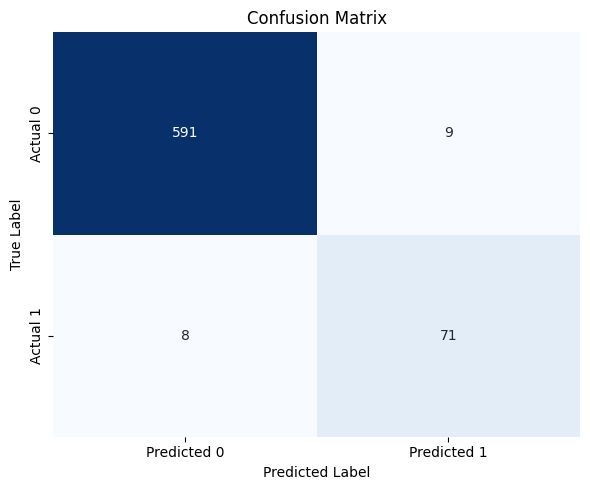

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test_true (true labels) and test_predictions_class (predicted classes) are defined
cm = confusion_matrix(y_test_true, test_predictions_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()